# Рекомендательная система

**Цель:** Определить понравится ли пользователю товар на основе истории его отзывов.

**Задача:** построить модель рекомендательной системы, которая будет предсказывать рейтинг покупатель-товар, предложить варианты решения проблемы холодного старта.

**Библиотеки:**

In [1]:
import numpy as np
import pandas as pd
import math
import scipy.sparse as sparse
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import sklearn
import json
import re
# import datetime

from lightfm import LightFM
#from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score

color = '#0e87cc'
#pd.set_option('display.max_columns', None)

**Подгружаем датасеты:**

In [2]:
train_df = pd.read_csv('data/train.csv', low_memory=False)
test_df = pd.read_csv('data/test.csv', low_memory=False)
submission = pd.read_csv('data/sample_submission.csv')

In [3]:
with open('data/meta_Grocery_and_Gourmet_Food.json') as f:
    meta_list = []
    for line in f.readlines():
        meta_list.append(json.loads(line))
meta_df = pd.DataFrame(meta_list)

In [4]:
# Сохраним meta_df в csv, чтоб не преобразовывать его каждый раз.
meta_df.to_csv('data/meta_food.csv', index=False)

In [5]:
# Закомментируем код 2-х ячеек выше и загрузим этот файл в формате csv
product_df = pd.read_csv('data/meta_food.csv', low_memory=False)

## Просмотр содержимого датасетов:

In [6]:
def count_nan(col, df):
    col_nan = np.round(df[col].isna().sum()/df.shape[0]*100, 1)
    print(f'Пропусков в {col}: {df[col].isna().sum()} - {col_nan} %')

### submission

Каждый id соответствует уникальной комбинации userid и itemid

In [7]:
submission.sample(5)

,Id,rating
30562,30562,0.161583
225309,225309,0.693254
15585,15585,0.425533
214553,214553,0.179306
349,349,0.161909


In [8]:
min_rating = np.round(submission['rating'].min(), 3)
max_rating = np.round(submission['rating'].max(), 3)
print(f'Диапозон рейтинга: {min_rating} - {max_rating}')

Диапозон рейтинга: 0.0 - 1.0


Для загрузки на Leaderboard необходимо представить данные id - rating (нормированный от 0 до 1).

### train

In [9]:
train_df.sample(5)

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating
184357,3.0,True,"12 12, 2013",B000EDK7ZQ,Salty-Sailor,"Product may be great, but the packaging from E...","Product may be great, but the packaging from E...",1386806400,3,{'Size:': ' 8 Ounce'},NaN,16178,1536,0.0
111427,5.0,True,"08 3, 2016",B000WV0RW8,ISUEE94,We keep coming back! We've bought these proba...,We keep coming back!,1470182400,NaN,NaN,NaN,20741,5173,1.0
574631,5.0,True,"07 4, 2016",B000I612BM,Kurt Eichenauer,Perfect!,Five Stars,1467590400,NaN,{'Flavor:': ' Plums'},NaN,18047,2756,1.0
668899,5.0,True,"03 28, 2016",B00EVJURRM,Waffle Lover,"Very nice product in a very nice container, sm...",Very nice product,1459123200,NaN,NaN,NaN,52543,24989,1.0
753141,3.0,True,"03 15, 2012",B001650XUK,Alison Q.,"Bought these in March 2012, the expration date...",Too close to expiration,1331769600,2,"{'Size:': ' 8 Ounce (Pack of 12)', 'Flavor:': ...",NaN,39129,6396,0.0


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857895 entries, 0 to 857894
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         857895 non-null  float64
 1   verified        857895 non-null  bool   
 2   reviewTime      857895 non-null  object 
 3   asin            857895 non-null  object 
 4   reviewerName    857719 non-null  object 
 5   reviewText      857616 non-null  object 
 6   summary         857725 non-null  object 
 7   unixReviewTime  857895 non-null  int64  
 8   vote            118740 non-null  object 
 9   style           444406 non-null  object 
 10  image           7142 non-null    object 
 11  userid          857895 non-null  int64  
 12  itemid          857895 non-null  int64  
 13  rating          857895 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(8)
memory usage: 85.9+ MB


Тренировочный датасет представляет собой список отзывов покупателей о товаре.

    overall - рейтинг, который поставил пользователь. Пропуски отсутствуют.
    verified - был ли отзыв верифицирован. Пропуски отсутствуют.
    reviewTime - когда был отзыв написан.
    reviewerName - имя пользователя
    asin - индивидуальный номер каждого товара, для идентификации товара и установления связи между датасетами
    reviewText - текст отзыва
    summary - сжатый отзыв
    vote - количество голосований за отзыв
    style - метаданные
    image - изображение продукта
    userid - id пользователя
    itemid - id товара
    id - id для предсказания (в тестовой выборке)

In [11]:
# Количество пропусков в каждой колонке:
train_df.isna().sum()

overall                0
verified               0
reviewTime             0
asin                   0
reviewerName         176
reviewText           279
summary              170
unixReviewTime         0
vote              739155
style             413489
image             850753
userid                 0
itemid                 0
rating                 0
dtype: int64

В тренировочном датасете представлено 857895 объектов. 

По некоторым признакам есть пропуски. Особенно много в колонках:

    vote (86%)- Количество голосов
    style (52%) - Данные, связанные с товаром
    image (99%) - Изображение продукта в виде ссылки

### test

Набор данных, для которого вы должны сделать предсказания. У каждого наобора userid, itemid есть свой id, для которого вы должны сделать предсказание.

In [12]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285965 entries, 0 to 285964
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   verified        285965 non-null  bool  
 1   reviewTime      285965 non-null  object
 2   asin            285965 non-null  object
 3   reviewerName    285918 non-null  object
 4   unixReviewTime  285965 non-null  int64 
 5   vote            39462 non-null   object
 6   style           147680 non-null  object
 7   image           2368 non-null    object
 8   userid          285965 non-null  int64 
 9   itemid          285965 non-null  int64 
 10  Id              285965 non-null  int64 
dtypes: bool(1), int64(4), object(6)
memory usage: 22.1+ MB


In [13]:
test_df.isna().sum()

verified               0
reviewTime             0
asin                   0
reviewerName          47
unixReviewTime         0
vote              246503
style             138285
image             283597
userid                 0
itemid                 0
Id                     0
dtype: int64

В тестовом датасете представлено 285965 объектов. 

Отсутсвуют некоторые признаки:

    overall  -  Общая оценка      
    reviewText - Текст отзыва     
    summary -  Суть отзыва        

    rating - его нам надо предсказать 
    
Так же содержится много пропусокв в колонках vote, style и image.

### product_df

In [14]:
product_df.sample(5)

,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
257938,"['Grocery & Gourmet Food', 'Candy & Chocolate']",['Assorted Fruit Chips Non-Menthol. A petite j...,Assorted Fruit Chips Chipurnoi Italian Cough D...,Chipurnoi,"519,232inGroceryGourmetFood(",['B000HRSGJ8'],Grocery,$22.95,B015E731FO,NaN,NaN,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
236528,"['Grocery & Gourmet Food', 'Candy & Chocolate'...","[""Imported from the UK for the holiday season,...",Rowntrees Pick and Mix Giant Tube - 140g by Ro...,Rowntree's,"684,296inGroceryGourmetFood(",NaN,Grocery,$9.99,B00U9W8Y20,NaN,NaN,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
127409,"['Grocery & Gourmet Food', 'Herbs, Spices & Se...",['Discover a livelier way to enjoy your favori...,"Whole Spice Grains of Paradise, 4 Ounce",Wholespice,"841,424inGroceryGourmetFood(",NaN,Grocery,NaN,B00AQI425A,NaN,['https://images-na.ssl-images-amazon.com/imag...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
23664,"['Grocery & Gourmet Food', 'Canned, Jarred & P...",['This sturgeon is indigenous to the Missouri ...,Bemka.com American Sturgeon Hackleback Wild Ca...,Bemka.com,"319,181inGroceryGourmetFood(","['B000HDJZEM', 'B00WT2M70S', 'B000QGL5Z2', 'B0...",Grocery,$45.00,B000QGK3G4,NaN,NaN,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
16890,"['Grocery & Gourmet Food', 'Candy & Chocolate'...",NaN,"Jelly Belly Chocolate Dutch Mints, Assorted Pa...",Jelly Belly,"316,853inGroceryGourmetFood(","['B00AYGEFD8', 'B00AQOSZRA', 'B00SQL2JF4', 'B0...",Grocery,$88.09,B000IKG0P6,NaN,['https://images-na.ssl-images-amazon.com/imag...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN


В данном датасете представлена информация о товарах - 287209 позиций.

In [15]:
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287209 entries, 0 to 287208
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   category      287209 non-null  object
 1   description   251802 non-null  object
 2   title         287205 non-null  object
 3   brand         275766 non-null  object
 4   rank          275494 non-null  object
 5   also_view     121012 non-null  object
 6   main_cat      285716 non-null  object
 7   price         132136 non-null  object
 8   asin          287209 non-null  object
 9   also_buy      83332 non-null   object
 10  image         150214 non-null  object
 11  date          9663 non-null    object
 12  feature       16374 non-null   object
 13  details       273323 non-null  object
 14  similar_item  256 non-null     object
 15  tech1         744 non-null     object
 16  fit           4 non-null       object
dtypes: object(17)
memory usage: 37.3+ MB


In [16]:
product_df.isna().sum()

category             0
description      35407
title                4
brand            11443
rank             11715
also_view       166197
main_cat          1493
price           155073
asin                 0
also_buy        203877
image           136995
date            277546
feature         270835
details          13886
similar_item    286953
tech1           286465
fit             287205
dtype: int64

Практически все признаки содержат много пропусков. Колонка 'asin' есть во всех датасетах. По ней будет стыковаться товар.

## Анализ датасетов

### train_df и test_df

Эти датасеты практически идентичны по признакам - будем рассматривать соместно.

**Удаление дубликатов**

Будем удалять только полное соответсвие объектов - точные копии строк.

In [17]:
print(f'Количество дубликатов строк в тренировочной выборке: {train_df.duplicated().sum()}')

Количество дубликатов строк в тренировочной выборке: 31000


In [18]:
train_df = train_df.drop_duplicates()

**rating**

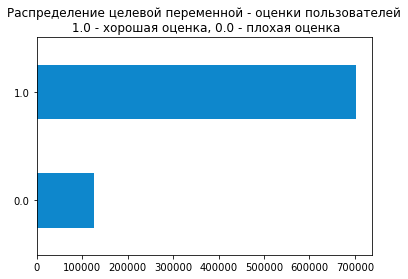

Перекос оценок: Хороших 85% - Плохих 15% - выборка относительно целевой переменной не сбалансирована


In [19]:
# Распределение целевой переменной - оценки пользователей
train_df['rating'].value_counts(ascending=True).plot(kind='barh', sort_columns=True, color=color,
                                                     title='Распределение целевой переменной - оценки пользователей\n 1.0 - хорошая оценка, 0.0 - плохая оценка'                                                    )
plt.show()

rating = train_df['rating'].value_counts(normalize=True)

print(f'Перекос оценок: Хороших {rating[1]*100:.0f}% - Плохих {rating[0]*100:.0f}%',
        '- выборка относительно целевой переменной не сбалансирована')

**overall**

In [20]:
train_df.groupby('rating')['overall'].value_counts()

rating  overall
0.0     3.0         58488
        1.0         36159
        2.0         30636
1.0     5.0        592278
        4.0        109334
Name: overall, dtype: int64

<AxesSubplot:xlabel='overall', ylabel='count'>

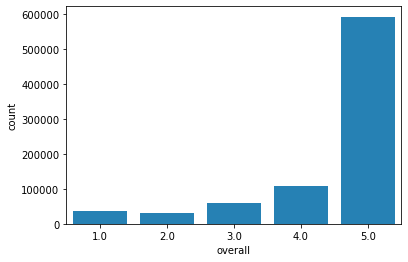

In [21]:
sns.countplot(x=train_df['overall'], color=color)

Большинство пользователей ставят оценку - 5, высоко оценивая товар. 

Оценки пользователей по 5-ти бальной шкале из 'overall' переведены в бинарную 'rating', которую нам и надо предсказать.

**verified**

In [22]:
train_df.verified.value_counts()

True     718164
False    108731
Name: verified, dtype: int64

Имеет два значения:

    True - отзыв подтвержден
    False - отзыв не подтвержден

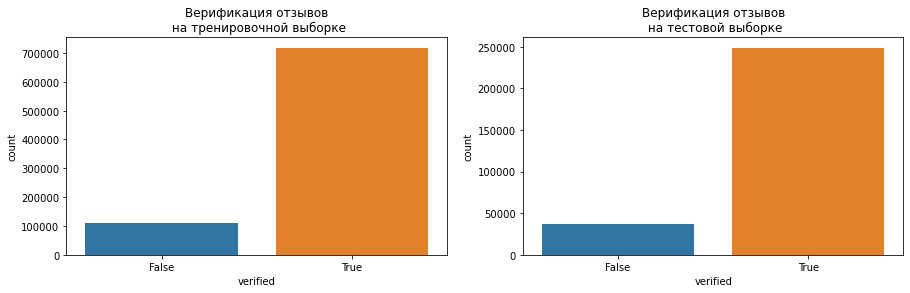

In [23]:
plt.figure(figsize=(15, 4))
plt.subplot(1,2,1)
plt.title('Верификация отзывов\n на тренировочной выборке')
sns.countplot(x=train_df.verified)
plt.subplot(1,2,2)
plt.title('Верификация отзывов\n на тестовой выборке')
sns.countplot(x=test_df.verified)

plt.show()

In [24]:
train_df.groupby('rating')['verified'].value_counts(normalize=True)

rating  verified
0.0     True        0.810956
        False       0.189044
1.0     True        0.878783
        False       0.121217
Name: verified, dtype: float64

Соотношение подтвержденных и неподтвержденных отзывов в тренировочной и тестовой выборках одинаковое. 

В тренировочной выборке наблюдается незначительный перекос подтвержденных и неподтвержденныз отзывов в разрезе рейтинга. В 0.0 значении рейтинга на 6.8% больше неподтверженных отзывов по сравнению с рейтингом 1.

Можно предположить, что рейтинги специально не накручивались за счет неподтвержденных отзывов.

In [25]:
# Заменим Thue и False на 1 и 0
train_df['verified'] = train_df['verified'].apply(int)
test_df['verified'] = test_df['verified'].apply(int)

**reviewTime** и **unixReviewTime**

Колонки с датами отзывов в которых даты записаны в разных форматах.

На основе их создадим колонку dateReview формата datatime, а reviewTime и unixReviewTime удалим.

In [26]:
train_df['dateReview'] = pd.to_datetime(train_df.reviewTime)
test_df['dateReview'] = pd.to_datetime(test_df.reviewTime)

In [27]:
train_df = train_df.drop(['reviewTime', 'unixReviewTime'], axis=1)
test_df = test_df.drop(['reviewTime', 'unixReviewTime'], axis=1)

За какой период размещены отзывы:

In [28]:
print(f'На тренировочной выборке: {train_df.dateReview.min().year} - {train_df.dateReview.max().year}')
print(f'На тестовой выборке: {test_df.dateReview.min().year} - {test_df.dateReview.max().year}')

На тренировочной выборке: 2000 - 2018
На тестовой выборке: 2002 - 2018


Аж целых 18 и 16 лет. Посмотрим по гистограмме распределение отзывов по годам размещения.

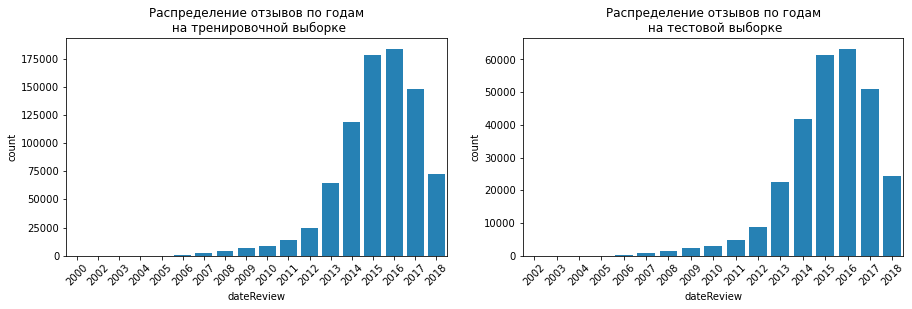

In [29]:
plt.figure(figsize=(15, 4))
plt.subplot(1,2,1)
plt.title('Распределение отзывов по годам\n на тренировочной выборке')
sns.countplot(x=train_df['dateReview'].apply(lambda d: d.year), color=color)
plt.xticks(rotation=45)
plt.subplot(1,2,2)
plt.title('Распределение отзывов по годам\n на тестовой выборке')
sns.countplot(x=test_df['dateReview'].apply(lambda d: d.year), color=color)
plt.xticks(rotation=45)

plt.show()

В основном отзывы более-менее свежие.

Сформируем признак - давность написания отзыва

In [30]:
train_df['dataAge'] = (train_df.dateReview.max() - train_df.dateReview).dt.days
test_df['dataAge'] = (test_df.dateReview.max() - test_df.dateReview).dt.days

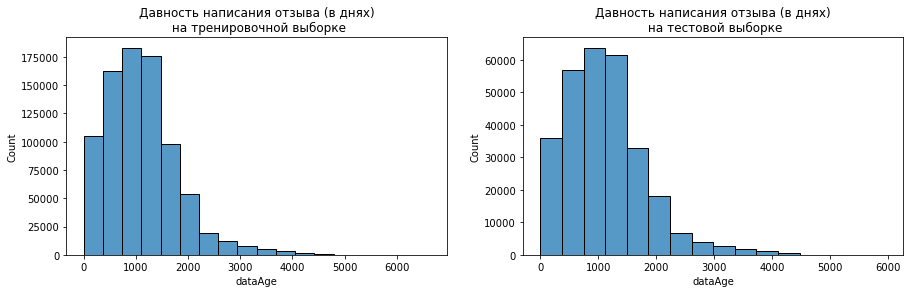

In [31]:
plt.figure(figsize=(15, 4))
plt.subplot(1,2,1)
plt.title('Давность написания отзыва (в днях)\n на тренировочной выборке')
sns.histplot(x=train_df['dataAge'], bins=18)
plt.subplot(1,2,2)
plt.title('Давность написания отзыва (в днях)\n на тестовой выборке')
sns.histplot(x=test_df['dataAge'], bins=16)

plt.show()

В основном интересны свежие отзывы. Можно отрубить хвост у распределения и привести его к нормальному. 

In [32]:
train_df['dataAge'] = train_df['dataAge'].apply(lambda x: x if x<2000 else 1500+x%500)
test_df['dataAge'] = test_df['dataAge'].apply(lambda x: x if x<2000 else 1500+x%500)

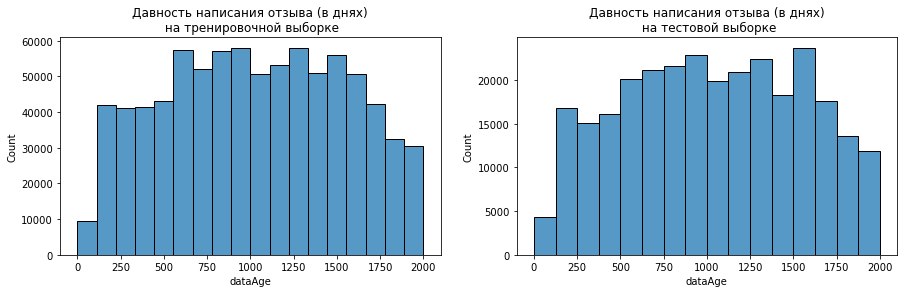

In [33]:
plt.figure(figsize=(15, 4))
plt.subplot(1,2,1)
plt.title('Давность написания отзыва (в днях)\n на тренировочной выборке')
sns.histplot(x=train_df['dataAge'], bins=18)
plt.subplot(1,2,2)
plt.title('Давность написания отзыва (в днях)\n на тестовой выборке')
sns.histplot(x=test_df['dataAge'], bins=16)

plt.show()

In [34]:
train_df['dateReview_week'] = train_df['dateReview'].apply(lambda d: d.day_of_week)
test_df['dateReview_week'] = test_df['dateReview'].apply(lambda d: d.day_of_week)

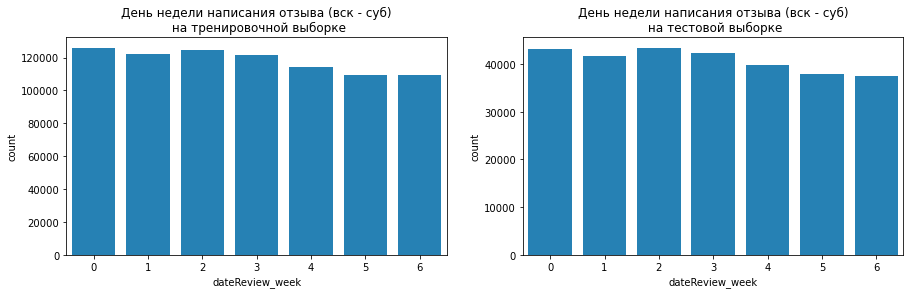

In [35]:
plt.figure(figsize=(15, 4))
plt.subplot(1,2,1)
plt.title('День недели написания отзыва (вск - суб)\n на тренировочной выборке')
sns.countplot(x=train_df['dateReview_week'], color=color)
plt.subplot(1,2,2)
plt.title('День недели написания отзыва (вск - суб)\n на тестовой выборке')
sns.countplot(x=test_df['dateReview_week'], color=color)

plt.show()

In [36]:
train_df['dateReview_month'] = train_df['dateReview'].apply(lambda d: d.month)
test_df['dateReview_month'] = test_df['dateReview'].apply(lambda d: d.month)

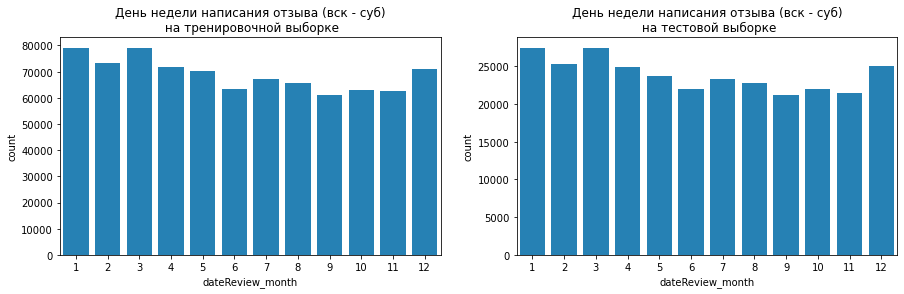

In [37]:
plt.figure(figsize=(15, 4))
plt.subplot(1,2,1)
plt.title('День недели написания отзыва (вск - суб)\n на тренировочной выборке')
sns.countplot(x=train_df['dateReview_month'], color=color)
plt.subplot(1,2,2)
plt.title('День недели написания отзыва (вск - суб)\n на тестовой выборке')
sns.countplot(x=test_df['dateReview_month'], color=color)

plt.show()

Обычно отзывы пишут сразу после покупки или начала использования. На графиках мы видим, что больше всего написано в январе и марте, чуть меньше декабрь и февраль. Похоже на связь с праздниками.

**reviewerName**

In [38]:
train_df.reviewerName.value_counts()[:7]

Amazon Customer    30612
Kindle Customer     6012
Linda                713
John                 695
David                597
Mary                 551
Mike                 550
Name: reviewerName, dtype: int64

In [39]:
test_df.reviewerName.value_counts()[:7]

Amazon Customer    10642
Kindle Customer     2060
Linda                254
John                 225
Michael              195
Karen                190
David                189
Name: reviewerName, dtype: int64

В обоих выборках большинство имен это Amazon Customer (Клиент Амазона) и Kindle Customer (Клиент Kindle). Можно предположить, что эти отзывы отправленны с их сервисов (если клиент не указал свое имя).

In [40]:
print(f'Количество пропусков в тренировочной выборке - {train_df.reviewerName.isna().sum()}')
print(f'Количество пропусков в тестовой выборке - {test_df.reviewerName.isna().sum()}')

Количество пропусков в тренировочной выборке - 164
Количество пропусков в тестовой выборке - 47


Пропусков немного. Можно заполнить их знаением 'Amazon Customer'. Посмотрим далее.

**vote**

Количество голосов за отзыв. Посмотрим на пропуски и значения.

In [41]:
print('На тренировочной выборке:')
count_nan("vote", train_df)
print('На тестовой выборке:')
count_nan("vote", test_df)

На тренировочной выборке:
Пропусков в vote: 712944 - 86.2 %
На тестовой выборке:
Пропусков в vote: 246503 - 86.2 %


В данной колонке очень большой процент пропусков - 86%. Клиенты не часто оценивают отзывы оставленные другими пользователями, обычно просто его читают. 

В основном, где значение заполненно, количество голосов за отзыв составляет от 2 до 6. Далее значения сильно падают. Есть ли смысл в этом признаке - пока неизвестно. 

Пропуски можно заполнить 0.

In [42]:
train_df.vote.value_counts()[:8]

2    42820
3    21447
4    12337
5     7932
6     5480
7     3833
8     2961
9     2291
Name: vote, dtype: int64

In [43]:
train_df['vote'] = train_df['vote'].fillna(0)
test_df['vote'] = test_df['vote'].fillna(0)

In [44]:
# Преобразуем все значения в числа, так как встречаются ','
train_df['vote'] = train_df['vote'].apply(lambda i: int(str(i).replace(',', '')))
test_df['vote'] = test_df['vote'].apply(lambda i: int(str(i).replace(',', '')))

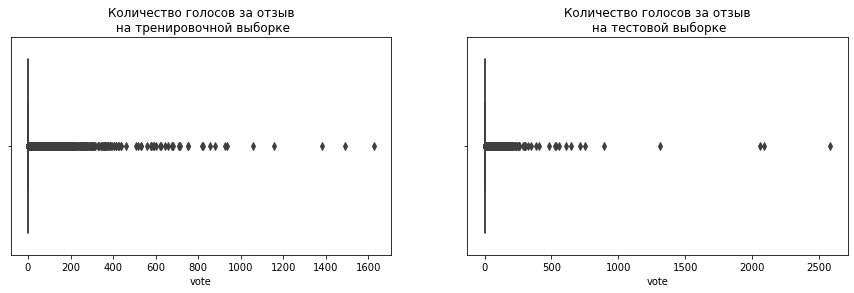

In [45]:
plt.figure(figsize=(15, 4))
plt.subplot(1,2,1)
plt.title('Количество голосов за отзыв\n на тренировочной выборке')
sns.boxplot(x=train_df['vote'])
plt.subplot(1,2,2)
plt.title('Количество голосов за отзыв\n на тестовой выборке')
sns.boxplot(x=test_df['vote'])

plt.show()

In [46]:
train_df['vote'].quantile(0.90)

2.0

Данные очень смещены. На 90 квантиле у нас значение 2. Все, что выше 8 - приравняем к 8.

In [47]:
train_df['vote'] = train_df['vote'].apply(lambda i: i if i<8 else 8)
test_df['vote'] = test_df['vote'].apply(lambda i: i if i<8 else 8)

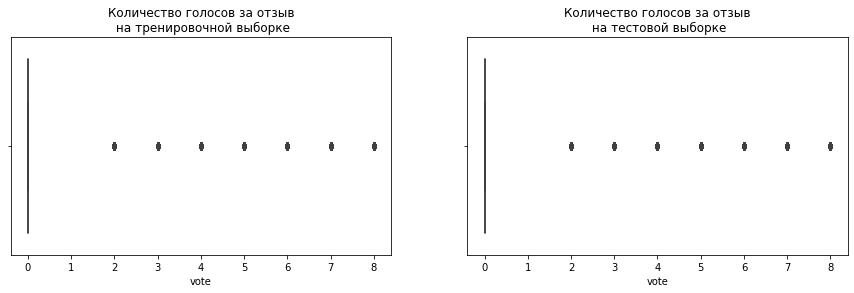

In [48]:
plt.figure(figsize=(15, 4))
plt.subplot(1,2,1)
plt.title('Количество голосов за отзыв\n на тренировочной выборке')
sns.boxplot(x=train_df['vote'])
plt.subplot(1,2,2)
plt.title('Количество голосов за отзыв\n на тестовой выборке')
sns.boxplot(x=test_df['vote'])

plt.show()

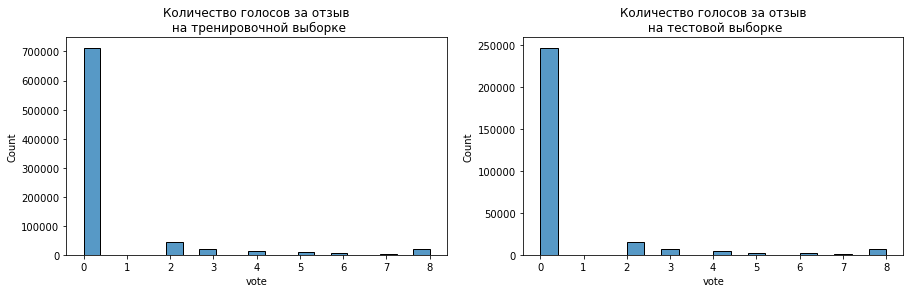

In [49]:
plt.figure(figsize=(15, 4))
plt.subplot(1,2,1)
plt.title('Количество голосов за отзыв\n на тренировочной выборке')
sns.histplot(x=train_df['vote'])
plt.subplot(1,2,2)
plt.title('Количество голосов за отзыв\n на тестовой выборке')
sns.histplot(x=test_df['vote'])

plt.show()

**style**

In [50]:
train_df[train_df['style'].isna() != True]['style'].sample(5)

283400    {'Size:': ' Pack of 1', 'Flavor:': ' Real Thea...
739176                      {'Size:': ' 12 oz (Pack of 4)'}
491705                  {'Style:': ' Medium Roast, Ground'}
121296    {'Size:': ' Pack of 24', 'Flavor:': ' Asian Pe...
519769                                  {'Size:': ' 2 lb.'}
Name: style, dtype: object

В колонке 'style' указан словарь с разными параметрами товаров, такие как размер, вкус/аромат, цвет и т.д.

In [51]:
print('На тренировочной выборке:')
count_nan('style', train_df)
print('На тестовой выборке:')
count_nan('style', test_df)

На тренировочной выборке:
Пропусков в style: 398698 - 48.2 %
На тестовой выборке:
Пропусков в style: 138285 - 48.4 %


Значения ключей: 'Size', 'Flavor', 'Package Quantity' 'Package Type', 'Format'

Достанем значения 'Size' - размер, объем, количество данного товара.  

In [52]:
def dict_col(d, key):
    try:
        if isinstance(d, str):
            d = d.split(',')
            for el in d:
                if key in el:
                    return el
    except:
        print('Ошибка -', d)
        return d
    return 


train_df['style_size'] = train_df['style'].apply(lambda d: dict_col(d, 'Size:'))
test_df['style_size'] = test_df['style'].apply(lambda d: dict_col(d, 'Size:'))

In [53]:
train_df['style_size'] = train_df['style_size'].apply(lambda s: str(s).replace("{'Size:': ' ", '' ).replace("'}", '' ).strip(" '"))
test_df['style_size'] = test_df['style_size'].apply(lambda s: str(s).replace("{'Size:': ' ", '' ).replace("'}", '' ).strip(" '"))

In [54]:
train_df['style_size'].value_counts()[:10]

None                    501280
24 Count                  9331
Pack of 1                 6233
1 Pack                    4967
12 Bars                   4906
Pack of 12                4570
16 Ounce                  4435
Pack of 6                 3871
12 Count                  3482
20 Count (Pack of 6)      3081
Name: style_size, dtype: int64

Есть однотипные значений по разному написанные. Можно достать просто цифры.

In [55]:
train_df['style_size_num'] = train_df['style_size'].astype(str).apply(lambda x: re.findall("\d+", x))
test_df['style_size_num'] = test_df['style_size'].astype(str).apply(lambda x: re.findall("\d+", x))

In [56]:
train_df['style_size_num'] = train_df['style_size_num'].apply(lambda x: int(x[0]) if len(x)>0 else 1)
test_df['style_size_num'] = test_df['style_size_num'].apply(lambda x: int(x[0]) if len(x)>0 else 1)
train_df['style_size_num'].value_counts()

1      557841
2       28188
12      26296
24      19654
16      18025
        ...  
102         1
129         1
151         1
97          1
69          1
Name: style_size_num, Length: 191, dtype: int64

Обычно товар представлен как 1,2, 12, 24, т.е. штуками и упаковками. Но так же встречаается в весовых показателях. Заменим их на 1. И 0 тоже заменим на 1.

In [57]:
train_df['style_size_num'] = train_df['style_size_num'].apply(lambda x: 1 if x>24 or x == 0 else x)
test_df['style_size_num'] = test_df['style_size_num'].apply(lambda x: 1 if x>24 or x == 0 else x)

**userid** и **itemid**

In [58]:
train_df.userid.value_counts()

842       418
17987     311
355       294
2024      288
2809      263
         ... 
29880       1
77384       1
103777      1
81564       1
100045      1
Name: userid, Length: 127448, dtype: int64

In [59]:
train_df.itemid.value_counts()

22208    5430
23540    4733
24556    4611
32046    2449
1919     2166
         ... 
21977       1
38542       1
39156       1
15582       1
36432       1
Name: itemid, Length: 41302, dtype: int64

Есть пользователи которые регулярно оставляют отзывы о товаре и оценивают его, а есть которые разово. Так как дубли удалены в самом начале, то это отзывы пользователя о разном товаре, и об одном товаре отзывы разных пользователей.

Можно сделать признак количество отзыва от данного покупатели и количество отзывов по данному товару. Так как скорее всего тренировочная и тестовая выборка это рандомное распределение общей базы, то тут думаю, что необходимо объединить эти базы и по ней сформировать словарь, в котором будет подсчитано количество.

In [60]:
df_tr = train_df[['userid', 'itemid', 'asin']]
df_ts = test_df[['userid', 'itemid', 'asin']]
df = pd.concat([df_tr, df_ts])
print(f'Количество дубликатов строк: {df.duplicated().sum()}')
df = df.drop_duplicates()

Количество дубликатов строк: 47436


In [61]:
userid_dict = df.userid.value_counts().to_dict()
itemid_dict = df.itemid.value_counts().to_dict()

In [62]:
# Активность пользователей по написанию отзывов
train_df['user_reviewer_num'] = train_df['userid'].apply(lambda x: userid_dict[x])
test_df['user_reviewer_num'] = test_df['userid'].apply(lambda x: userid_dict[x])

In [63]:
# Популярнось товара у активных пользователей
train_df['item_reviewer_num'] = train_df['itemid'].apply(lambda x: itemid_dict[x])
test_df['item_reviewer_num'] = test_df['itemid'].apply(lambda x: itemid_dict[x])

In [64]:
del df_tr
del df_ts
del df

### product_df

**Удаление дубликатов**

In [65]:
print(f'Количество дубликатов строк в выборке информации о товаре: {product_df.duplicated().sum()}')

Количество дубликатов строк в выборке информации о товаре: 3697


In [66]:
product_df = product_df.drop_duplicates()

**title**

Название товара.

В title всего 4 пропуска. Заполним их вручную, выбрав информацию из 'details'

In [67]:
product_df[product_df.title.isna()][['asin', 'category', 'title', 'main_cat', 'description', 'details']]

,asin,category,title,main_cat,description,details
30094,B00104HAOO,"['Grocery & Gourmet Food', 'Herbs, Spices & Se...",NaN,Grocery,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul..."
51120,B001TO12N0,"['Grocery & Gourmet Food', 'Sauces, Gravies & ...",NaN,NaN,['Sweet Chili Sauce'],"\n <div class=""content"">\n\n\n\n\n\n\n\n<ul>\..."
211916,B00N2FVDGA,"['Grocery & Gourmet Food', 'Beverages', 'Coffe...",NaN,Grocery,['An elegantly balanced blend of light and dar...,"\n <div class=""content"">\n\n\n\n\n\n\n<ul..."
212457,B00N4QFR32,"['Grocery & Gourmet Food', 'Snack Foods', 'Pop...",NaN,Grocery,"[""The Pop Crazy 3 Piece Popcorn Party Pack com...","\n <div class=""content"">\n\n\n\n\n\n\n<ul..."


In [68]:
# Пропусков в title мало - быстрее вручную пробежать по details в этой строке
product_df.iloc[30094].title = 'Peppercorns'
product_df.iloc[51120].title = 'Chili Sauce'
product_df.iloc[211916].title = 'Single-Serve Capsules & Pods'
product_df.iloc[212457].title = 'Popcorn'

Некоторые товары имеют одинаковое название. Хорошо бы создать колонку, выделив главные названия без описательных, например чай, шоколад и т.д. Попробуем если будет время.

In [69]:
product_df.asin.nunique() - product_df.title.nunique() 

1871

**category**

Признак содержит вложенность (иерархию) категорий товара. 

В 'category' все объекты начинаются с 'Grocery & Gourmet Food' => Удалим

In [70]:
product_df['category'] = product_df['category'].apply(lambda x: str(x).replace("['Grocery & Gourmet Food', ", '').replace('"', "'").replace("']", ""))

In [71]:
product_df['category'] 

0                  'Dairy, Cheese & Eggs', 'Cheese', 'Gouda
1         'Cooking & Baking', 'Sugar Substitutes', 'Xylitol
2         'Cooking & Baking', 'Frosting, Icing & Decorat...
3         'Cooking & Baking', 'Frosting, Icing & Decorat...
4         'Cooking & Baking', 'Frosting, Icing & Decorat...
                                ...                        
287204    'Jams, Jellies & Sweet Spreads', 'Jams, Jellie...
287205          'Condiments & Salad Dressings', 'Mayonnaise
287206    'Condiments & Salad Dressings', 'Salad Dressin...
287207    'Herbs, Spices & Seasonings', 'Single Herbs & ...
287208    'Beverages', 'Bottled Beverages, Water & Drink...
Name: category, Length: 283512, dtype: object

In [72]:
product_df['num_category_1'] = product_df['category'].apply(lambda x: x.split("', '")[0].replace("'", ""))
product_df['num_category_1'].value_counts() 

Beverages                             61035
Cooking & Baking                      45556
Candy & Chocolate                     40398
Snack Foods                           32076
Herbs, Spices & Seasonings            18852
Sauces, Gravies & Marinades           10673
Canned, Jarred & Packaged Foods        9987
Food & Beverage Gifts                  9494
Breakfast Foods                        7514
Condiments & Salad Dressings           4814
Produce                                4701
Jams, Jellies & Sweet Spreads          4692
Soups, Stocks & Broths                 4597
Dairy, Cheese & Eggs                   4526
Meat & Seafood                         4475
Breads & Bakery                        3997
Dried Beans, Grains & Rice             3450
Pasta & Noodles                        3396
Olives, Pickles & Relishes             2615
Fresh Flowers & Live Indoor Plants     2599
Frozen                                 2474
Prepared Foods                          642
Deli                            

In [73]:
product_df['num_category_2'] = product_df['category'].apply(lambda x: x.split("', '")[1] if len(x.split("', '"))>1 else x.split("', '")[0].replace("'", ""))
product_df['num_category_2'].value_counts()

Coffee, Tea & Cocoa                                                                                         44626
Bottled Beverages, Water & Drink Mixes                                                                      15283
Frosting, Icing & Decorations                                                                               10702
Jelly Beans & Gummy Candy                                                                                    8270
Cookies                                                                                                      8022
                                                                                                            ...  
Alcoholic Beverages                                                                                             3
20 easy prefilled Easter eggs with 3 candy assortments including Brach's Jellybeans and Chewy Lemonheads        3
Pulled & Flaked Meats                                                                   

In [74]:
product_df['num_category_3'] = product_df['category'].apply(lambda x: x.split("', '")[2] if len(x.split("', '"))>2 else  x.split("', '")[-1].replace("'", ""))
product_df['num_category_3'].value_counts()

Tea                                                                                                                    23148
Coffee                                                                                                                 18508
Cake & Cupcake Toppers                                                                                                  8311
Candy & Chocolate Bars                                                                                                  7456
Hard Candy                                                                                                              4769
                                                                                                                       ...  
Variety Packs                                                                                                              1
Potash Baking Ingredient                                                                                                   1


Колонки 'num_category_2' и 'num_category_3' в некоторых строках содержат описание, а не названия категорий. Заменим их.

In [75]:
product_df['num_category_2'] = product_df['num_category_2'].apply(lambda x: 'Other' if len(str(x))>50 else x)
product_df['num_category_2'].value_counts()

Coffee, Tea & Cocoa                       44626
Bottled Beverages, Water & Drink Mixes    15283
Frosting, Icing & Decorations             10702
Jelly Beans & Gummy Candy                  8270
Cookies                                    8022
                                          ...  
Nuggets & Wings                               4
Jerky                                         4
Roasted Chicken                               4
Alcoholic Beverages                           3
Pulled & Flaked Meats                         2
Name: num_category_2, Length: 251, dtype: int64

In [76]:
product_df['num_category_3'] = product_df['num_category_3'].apply(lambda x: 'Other' if len(str(x))>50 else x)
product_df['num_category_3'].value_counts()

Tea                                      23148
Coffee                                   18508
Cake & Cupcake Toppers                    8311
Candy & Chocolate Bars                    7456
Hard Candy                                4769
                                         ...  
Made in USA or Imported                      1
Fruit Relishes                               1
DISNEY'S FROZEN FILLED EASTER BASKET.        1
100% Cotton                                  1
Sake & Rice Spirits                          1
Name: num_category_3, Length: 855, dtype: int64

Если в обучении будут использоваться num_category_3 и num_category_3, то надо будет сгруппировать данные. Предположительно если значений такой категории менее 50, то берем родительскую. И Other тоже заменим на родительскую категорию

**description**

Признак содержит описание товара, состав. 

In [77]:
# пример описания отвара
product_df['description'][192595]

"['Every bite is moist and full of flavor with walnuts, carrots, raisins, coconut and cinnamon. They taste just like you are biting into a Mini Carrot Cake but they are GUILT-FREE!', 'Ingredients: organic walnuts, fresh organic carrots, organic maple syrup, organic gluten-free oats, organic raisins, organic almonds, organic coconut, organic cashews, organic extra virgin coconut oil, pink himalayan salt, organic spices', 'Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, treat, cure, or prevent any disease or health condition.']"

In [78]:
count_nan('description', product_df)

Пропусков в description: 34966 - 12.3 %


**brand**

In [79]:
product_df['brand'].value_counts()

Unknown                   1584
Black Tie Mercantile      1458
Trader Joe's              1234
McCormick                 1022
The Nutty Fruit House      998
                          ... 
MoreA                        1
3 ProArgi 9 Plus Boxes       1
TOTLE                        1
Yogavni(TM)                  1
Dhrob                        1
Name: brand, Length: 38911, dtype: int64

In [80]:
product_df['brand'].nunique()

38911

Достаточно большое разнообразие брендов. Так же имеются пропуски.

In [81]:
count_nan('brand', product_df)

Пропусков в brand: 11259 - 4.0 %


Есть универсальное значение 'Unknown' - вот им и заполним пропуски и те, которых очень мало.

In [82]:
product_df['brand'] = product_df['brand'].fillna('Unknown')

In [83]:
brand_sr = product_df['brand'].value_counts()
product_df['brand'].value_counts()

Unknown                   12843
Black Tie Mercantile       1458
Trader Joe's               1234
McCormick                  1022
The Nutty Fruit House       998
                          ...  
MoreA                         1
3 ProArgi 9 Plus Boxes        1
TOTLE                         1
Yogavni(TM)                   1
Dhrob                         1
Name: brand, Length: 38911, dtype: int64

In [84]:
brand_sr[brand_sr < 5].sum()

47278

После заполнения пропусков уже пошел сильно большой перекос в сторону Unknown, а если на него отнести значения у брендов с малым количеством, то будет еще гораздо хуже. 

**rank**

По данным похоже, что в этой колонке отображен ранг (позиция) в категориях или позиция в номенклатуре. Так как если взять объект 4, то видим похожую с признаком 'category' вложенность.

In [85]:
product_df['category'][4]

"'Cooking & Baking', 'Frosting, Icing & Decorations', 'Cake & Cupcake Toppers', 'Cake Toppers"

In [86]:
product_df['rank'][4]

'>#590,999 in Kitchen & Dining (See Top 100 in Kitchen & Dining)>#8,585 in Kitchen & Dining > Bakeware > Decorating Tools > Cake & Cupcake Toppers > Cake Toppers'

In [87]:
product_df['rank'] = product_df['rank'].astype(str).apply(lambda x: re.findall("\d+,\d+", x))

In [88]:
def rank_number(x):
    if len(x)>=1:
        to_return = int(x[0].replace(',',''))
    else:
        to_return = None
    return to_return
product_df['rank'] = product_df['rank'].apply(lambda x: rank_number(x))
product_df['rank'] 

0         165181.0
1         315867.0
2         669941.0
3         832581.0
4         590999.0
            ...   
287204    369384.0
287205    113710.0
287206     21731.0
287207         NaN
287208    265258.0
Name: rank, Length: 283512, dtype: float64

<AxesSubplot:>

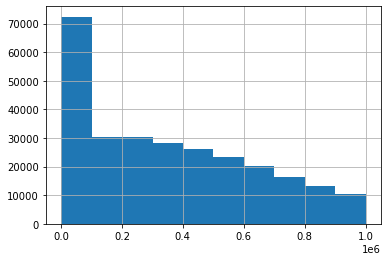

In [89]:
product_df['rank'].hist()

In [90]:
product_df['rank'].min(), product_df['rank'].max()

(1000.0, 999998.0)

In [91]:
count_nan('rank', product_df)

Пропусков в rank: 12324 - 4.3 %


Заполним пропуски по median 'rank' исходя из категории_3

In [92]:
rank_dict_3 = product_df.groupby('num_category_3')['rank'].median().to_dict()
def fill_rank_3(row):
    if row['rank']>0:
        return row['rank']
    
    return rank_dict_3[row['num_category_3']]

product_df['rank'] = product_df.apply(lambda x: fill_rank_3(x), axis=1)
count_nan('rank', product_df)

Пропусков в rank: 92 - 0.0 %


In [93]:
rank_dict_2 = product_df.groupby('num_category_2')['rank'].median().to_dict()
def fill_rank_2(row):
    if row['rank']>0:
        return row['rank']
    
    return rank_dict_2[row['num_category_2']]

product_df['rank'] = product_df.apply(lambda x: fill_rank_2(x), axis=1)
count_nan('rank', product_df)

Пропусков в rank: 9 - 0.0 %


In [94]:
rank_dict_1 = product_df.groupby('num_category_1')['rank'].median().to_dict()
def fill_rank_1(row):
    if row['rank']>0:
        return row['rank']
    
    return rank_dict_1[row['num_category_1']]

product_df['rank'] = product_df.apply(lambda x: fill_rank_1(x), axis=1)
count_nan('rank', product_df)

Пропусков в rank: 0 - 0.0 %


**also_view** и **also_buy**

В этой колонке содержится признак asin товаров, которые так же смотрят (also_view) и покупают (also_buy) с этим товаром

In [95]:
product_df['also_view']

0         ['B0000D9MYM', 'B0000D9MYL', 'B00ADHIGBA', 'B0...
1                                                       NaN
2                                            ['B07DXN65TF']
3                                                       NaN
4                                                       NaN
                                ...                        
287204                                                  NaN
287205                                                  NaN
287206                                                  NaN
287207                                                  NaN
287208    ['B007JFV6RK', 'B005VS60ZK', 'B01BV8YFYG', 'B0...
Name: also_view, Length: 283512, dtype: object

In [96]:
count_nan('also_view', product_df)

Пропусков в also_view: 164588 - 58.1 %


In [97]:
product_df['also_buy']

0                                                       NaN
1         ['B01898YHXK', 'B01BCM6LAC', 'B00Q4OL47O', 'B0...
2                                                       NaN
3                                                       NaN
4                                                       NaN
                                ...                        
287204    ['B01HULC3TC', 'B07C8L4NWL', 'B014UTG6D6', 'B0...
287205    ['B00WNAEX2Q', 'B071LD7PMJ', 'B01HJF6FRA', 'B0...
287206    ['B071LD7PMJ', 'B00KOHNX6C', 'B00OVN2F64', 'B0...
287207    ['B00DUF219A', 'B01HJHX9ZO', 'B07K4K26PQ', 'B0...
287208                                                  NaN
Name: also_buy, Length: 283512, dtype: object

In [98]:
count_nan('also_buy', product_df)

Пропусков в also_buy: 201204 - 71.0 %


Эти признаки очень возможно пригодятся. Пока непонятно в каком формате они понадобиться и как их лучше обработать.

**main_cat**

Главная категория товара.

In [99]:
product_df.main_cat.value_counts()

Grocery                         258555
Amazon Home                       8841
Health & Personal Care            8435
Toys & Games                      1933
All Beauty                        1596
Industrial & Scientific            977
Office Products                    610
Sports & Outdoors                  389
Cell Phones & Accessories          167
Arts, Crafts & Sewing              129
Pet Supplies                       128
Baby                                95
Tools & Home Improvement            66
Computers                           39
All Electronics                     20
Home Audio & Theater                14
Automotive                           7
Movies & TV                          4
Camera & Photo                       3
Musical Instruments                  3
Software                             2
Video Games                          2
Appliances                           1
Portable Audio & Accessories         1
Car Electronics                      1
Gift Cards               

 Данные категории содержат мало товаров, но в принципе они смежные по тематике:
 
    Computers                           39
    All Electronics                     20
    Home Audio & Theater                14
    Automotive                           7
    Movies & TV                          4
    Camera & Photo                       3
    Musical Instruments                  3
    Software                             2
    Video Games                          2
    Appliances                           1
    Portable Audio & Accessories         1
    Car Electronics                      1
    Gift Cards                           1  
    
Возможно их объеденить в одну - Electronics.

In [100]:
Electronics = ['Computers', 'All Electronics', 'Home Audio & Theater', 'Automotive', 'Movies & TV', 'Camera & Photo',
               'Musical Instruments', 'Software', 'Video Games', 'Appliances', 'Portable Audio & Accessories',
               'Car Electronics', 'Gift Cards']
product_df['main_cat'] = product_df['main_cat'].apply(lambda x: 'Electronics' if x in Electronics else x)
product_df.main_cat.value_counts()

Grocery                      258555
Amazon Home                    8841
Health & Personal Care         8435
Toys & Games                   1933
All Beauty                     1596
Industrial & Scientific         977
Office Products                 610
Sports & Outdoors               389
Cell Phones & Accessories       167
Arts, Crafts & Sewing           129
Pet Supplies                    128
Electronics                      98
Baby                             95
Tools & Home Improvement         66
Name: main_cat, dtype: int64

In [101]:
count_nan('main_cat', product_df)

Пропусков в main_cat: 1493 - 0.5 %


In [102]:
product_df[product_df['main_cat'].isna()]['num_category_1'].value_counts()

Fresh Flowers & Live Indoor Plants    322
Cooking & Baking                      270
Candy & Chocolate                     204
Beverages                             201
Snack Foods                           147
Food & Beverage Gifts                  72
Herbs, Spices & Seasonings             56
Sauces, Gravies & Marinades            33
Soups, Stocks & Broths                 31
Produce                                24
Meat & Seafood                         21
Breakfast Foods                        19
Condiments & Salad Dressings           16
Canned, Jarred & Packaged Foods        15
Breads & Bakery                        12
Olives, Pickles & Relishes             10
Jams, Jellies & Sweet Spreads           9
Dried Beans, Grains & Rice              9
Dairy, Cheese & Eggs                    8
Pasta & Noodles                         8
Alcoholic Beverages                     3
Frozen                                  3
Name: num_category_1, dtype: int64

Пропуски можно заполнить опираясь на данные 'num_category_1'. Если еда, то 'Grocery',  а там все еда, кроме 'Fresh Flowers & Live Indoor Plants', которую отнести на 'Amazon Home'

In [103]:
main_cat_fill = product_df[product_df['main_cat'].isna()]['num_category_1'].value_counts().to_dict()
for key, _ in main_cat_fill.items():
    if key == 'Fresh Flowers & Live Indoor Plants':
        main_cat_fill[key] = 'Amazon Home'
    else:
        main_cat_fill[key] = 'Grocery'  

In [104]:
product_df['main_cat'] = product_df['main_cat'].fillna(0)
product_df['main_cat'] = product_df.apply(lambda row: main_cat_fill[row['num_category_1']] if row['main_cat'] == 0 else row['main_cat'] , axis=1)

In [105]:
product_df.main_cat.value_counts()

Grocery                      259726
Amazon Home                    9163
Health & Personal Care         8435
Toys & Games                   1933
All Beauty                     1596
Industrial & Scientific         977
Office Products                 610
Sports & Outdoors               389
Cell Phones & Accessories       167
Arts, Crafts & Sewing           129
Pet Supplies                    128
Electronics                      98
Baby                             95
Tools & Home Improvement         66
Name: main_cat, dtype: int64

In [106]:
count_nan('main_cat', product_df)

Пропусков в main_cat: 0 - 0.0 %


**price**

In [107]:
count_nan('price', product_df)

Пропусков в price: 153278 - 54.1 %


Цена может повлиять на выбор схожих товаров. Т.е. второй или третий по степени значимости показатель (первое, это что хочет покупатель преобрести, а потом уже обычно бренд (марка) и цена идут). Но пропусков очень много. 

In [108]:
product_df['price']

0         $41.91
1            NaN
2         $29.95
3         $11.45
4         $15.00
           ...  
287204       NaN
287205    $10.89
287206    $10.95
287207    $14.97
287208    $18.00
Name: price, Length: 283512, dtype: object

In [109]:
product_df[product_df['price'].apply(lambda x: '-' in str(x))][['title', 'price']].shape

(100, 2)

У 100 товаров установлен диапозон цен. Наверное, зависит от объема, который покупатель закажет. Возьмем нижнее значение.

In [110]:
product_df['price'] = product_df['price'].apply(lambda x: float(str(x).split('-')[0].replace('$', '').replace(',', '')) if x else x)
product_df['price']

0         41.91
1           NaN
2         29.95
3         11.45
4         15.00
          ...  
287204      NaN
287205    10.89
287206    10.95
287207    14.97
287208    18.00
Name: price, Length: 283512, dtype: float64

Заполним пропуски медианным значением по категории.

In [111]:
price_dict_3 = product_df.groupby('num_category_3')['price'].median().to_dict()
def fill_price_3(row):
    if row['price']>0:
        return row['price']
    
    return price_dict_3[row['num_category_3']]

product_df['price'] = product_df.apply(lambda x: fill_price_3(x), axis=1)
count_nan('price', product_df)

Пропусков в price: 600 - 0.2 %


In [112]:
price_dict_2 = product_df.groupby('num_category_2')['price'].median().to_dict()
def fill_price_2(row):
    if row['price']>0:
        return row['price']
    
    return price_dict_2[row['num_category_2']]

product_df['price'] = product_df.apply(lambda x: fill_price_2(x), axis=1)
count_nan('price', product_df)

Пропусков в price: 203 - 0.1 %


In [113]:
price_dict_1 = product_df.groupby('num_category_1')['price'].median().to_dict()
def fill_price_1(row):
    if row['price']>0:
        return row['price']
    
    return price_dict_1[row['num_category_1']]

product_df['price'] = product_df.apply(lambda x: fill_price_1(x), axis=1)
count_nan('price', product_df)

Пропусков в price: 8 - 0.0 %


In [114]:
product_df[product_df['price'].isna()][['num_category_1','title', 'price']]

,num_category_1,title,price
233138,Fresh Meal Kits,Evie's Pork Tenderloin with Roasted Red Pepper...,NaN
243562,Fresh Meal Kits,Evie's Pork Chops with Smashed Potatoes Meal K...,NaN
243563,Fresh Meal Kits,Evie's Chicken Breast Caprese with Orzo Meal K...,NaN
243565,Fresh Meal Kits,"Evie's Steak Fajita Meal Kit, 2 Servings, 43 oz",NaN
280801,Fresh Meal Kits,"Amazon Meal Kits, Orecchiette Pasta with Itali...",NaN
282537,Fresh Meal Kits,"Amazon Meal Kits, Thai Red Curry with Chicken ...",NaN
282538,Fresh Meal Kits,"Amazon Meal Kits, Veggie Quinoa Bowl with Spic...",NaN
284352,Fresh Meal Kits,"Amazon Meal Kits, Parmesan Pork Loin with Tang...",NaN


In [115]:
product_df['price'] = product_df['price'].fillna(product_df['price'].median())

**date**

Похоже на дату внесения данного товара в базу. Данных очень мало.

In [116]:
count_nan('date', product_df)

Пропусков в date: 273937 - 96.6 %


**feature**

Содержит описание товара, его осбенности.

In [117]:
product_df['feature'].value_counts()[:5]

['High quality edibles to decorate your cupcakes, cookies, baked goods and ice cream; Items within same container may vary slightly in shade', 'This product is prepared and packaged using machines that may come in contact with Wheat/Gluten, Eggs, Dairy Products, Peanuts, Soy, and Tree Nuts', 'Store in cool, dry area for long shelf life', 'Certified Kosher, Made in the USA', 'Combine with Dress My Cupcake wrappers, tissue pom poms and vintage straws to complete your dessert table']                                                                                                                                                                                                                                                           113
['One of our core values is to treat each other with dignity and respect.', 'Our commitment is to strengthen every community we serve.', "We care about your coffee 'from crop to cup' and every step in between.", 'We believe our purchases and partnerships help 

In [118]:
count_nan('feature', product_df)

Пропусков в feature: 267294 - 94.3 %


Но очень-очень много пропусков. Такой признак не стоит использовать.

**similar_item, tech1, details и fit**

Подробности о товаре, но данные очень замусорены и пропусков практиески 100%. Использовать в обучении не будем. Польза от этих данных может быть только для заполнения пропусков в других колонках.

In [119]:
product_df['similar_item'].value_counts()[:1]

[{'asin': '', 'href': '', 'name': 'Wilton Bake Easy Non-Stick Spray', 'img': 'https://images-na.ssl-images-amazon.com/images/I/41WpJ5WkSHL._SL500_AC_SS350_.jpg', 'features': {'Customer Rating': '4 out of 5 stars\n\n(69)', 'Price': 'From $3.49', 'Shipping': '', 'Sold By': 'Available from these sellers', 'Color': 'A', 'Material Type': 'Other'}}, {'asin': 'B007E8KCCM', 'href': '/dp/B007E8KCCM/ref=psdc_2231402011_t1_B0000A9XZO', 'name': 'Wilton 417-1154 Icing Smoother Comb Set-3 Piece, White/Purple', 'img': 'https://images-na.ssl-images-amazon.com/images/I/41B7eT3WJZL._SL500_AC_SS350_.jpg', 'features': {'Customer Rating': '4 out of 5 stars\n\n(48)', 'Price': '$12.49', 'Shipping': 'Eligible for FREE Shipping', 'Sold By': 'Amazon.com', 'Color': 'White/Purple', 'Material Type': 'Plastic'}}, {'asin': 'B007E8KCFY', 'href': '/dp/B007E8KCFY/ref=psdc_2231402011_t2_B0000A9XZO', 'name': 'Wilton Cake Leveler, Small, 10-Inch\n\n\n\n\n\n        #1 Best Seller', 'img': 'https://images-na.ssl-images-amaz

In [120]:
count_nan('similar_item', product_df)

Пропусков в similar_item: 283264 - 99.9 %


In [121]:
count_nan('tech1', product_df)

Пропусков в tech1: 282769 - 99.7 %


In [122]:
count_nan('details', product_df)

Пропусков в details: 13759 - 4.9 %


In [123]:
count_nan('fit', product_df)

Пропусков в fit: 283508 - 100.0 %


### Сформируем датасет признаков

In [124]:
col_feature = ['itemid', 'userid', 'verified', 'vote', 'dataAge', 'dateReview_week',
       'dateReview_month', 'style_size_num', 'user_reviewer_num', 'item_reviewer_num',  'asin']
feature_df = pd.concat([train_df[col_feature], test_df[col_feature]])

feature_df = pd.merge(feature_df, product_df, on='asin')


### Создадим dummy-переменные категориальных данных

In [125]:
feature_df['dateReview_week_all'] = feature_df['dateReview_week']
feature_df['dateReview_month_all'] = feature_df['dateReview_month']
feature_df['main_cat_all'] = feature_df['main_cat']
feature_df['num_category_1_all'] = feature_df['num_category_1']

feature_df = pd.get_dummies(feature_df, columns=['dateReview_week', 'dateReview_month', 'main_cat', 'num_category_1'], prefix_sep = '_')

Закодируем слова в цифры (иерархия по количеству встречаемости)

In [126]:
main_cat_all_dict = {'Grocery': 14,
                     'Health & Personal Care': 13,
                     'Amazon Home': 12,
                     'All Beauty': 11,
                     'Sports & Outdoors': 10,
                     'Industrial & Scientific': 9,
                     'Office Products': 8,
                     'Toys & Games': 7,
                     'Pet Supplies': 6,
                     'Tools & Home Improvement': 5,
                     'Baby': 4,
                     'Electronics': 3,
                     'Arts, Crafts & Sewing': 2,
                     'Cell Phones & Accessories': 1}
feature_df['main_cat_all'] = feature_df['main_cat_all'].apply(lambda x: main_cat_all_dict[x])

In [127]:
num_category_1_all_dict = {'Beverages': 25,
                           'Cooking & Baking': 24,
                           'Snack Foods': 23,
                           'Candy & Chocolate': 22,
                           'Herbs, Spices & Seasonings': 21,
                           'Breakfast Foods': 20,
                           'Canned, Jarred & Packaged Foods': 19,
                           'Produce': 18,
                           'Soups, Stocks & Broths': 17,
                           'Sauces, Gravies & Marinades': 16,
                           'Jams, Jellies & Sweet Spreads': 15,
                           'Dairy, Cheese & Eggs': 14,
                           'Dried Beans, Grains & Rice': 13,
                           'Pasta & Noodles': 12,
                           'Condiments & Salad Dressings': 11,
                           'Food & Beverage Gifts': 10,
                           'Breads & Bakery': 9,
                           'Meat & Seafood': 8,
                           'Frozen': 7,
                           'Olives, Pickles & Relishes': 6,
                           'Fresh Flowers & Live Indoor Plants': 5,
                           'Prepared Foods': 4,
                           'Meat Substitutes': 3,
                           'Deli': 2,
                           'Alcoholic Beverages': 1}
feature_df['num_category_1_all'] = feature_df['num_category_1_all'].apply(lambda x: num_category_1_all_dict[x])

## Обучение модели

In [128]:
# Чтоб числа вещественные выводились норм
pd.options.display.float_format ='{:,.5f}'.format

In [129]:
def get_norm(pred):
    """Нормирование предсказания от 0 до 1"""
    return (pred-pred.min())/(pred.max()-pred.min())

def get_metrics(y, pred):
    """Метрики качества обучения"""
    mse = mean_squared_error(y, pred)
    mae = mean_absolute_error(y, pred)
    roc_auc = roc_auc_score(y, pred)
    print('mse: ', mse)
    print('mae: ', mae)
    print('roc-auc: ', roc_auc)
    
    return {'mse': mse, 'mae': mae, 'roc-auc': roc_auc}
    
    
    

In [130]:
# Гиперпараметры
RANDOM_STATE = 42
LEARNING_RATE = 0.1
LOSS_FUNC = 'logistic' # Нужны +1 и -1 => в rating заменим 0 на -1
NUM_COMPONENTS = 110 # поиграть с этим параметром - число параметров вектора 
NUM_EPOCHS = 10 #число эпох обучения
NUM_THREADS = 4 #число потоков

In [131]:
train_df['rating'] = train_df['rating'].apply(lambda x: -1 if x == 0 else x)
train_df['rating'].value_counts()

1.00000     701612
-1.00000    125283
Name: rating, dtype: int64

In [132]:
X_train, X_test = train_test_split(train_df, random_state = RANDOM_STATE, test_size=0.2, shuffle = True)

In [133]:
ratings_coo = sparse.coo_matrix(
    (X_train['rating'].astype(int), (X_train['userid'], X_train['itemid']))
)

### Базовая модель, не учитывающая признаки товаров и пользователей

In [134]:
# Создадим словарь, в который будем собирать метрики по каждой модели
metrics_model = {}

In [135]:
model = LightFM(
    learning_rate=LEARNING_RATE,
    loss=LOSS_FUNC,
    no_components=NUM_COMPONENTS,
    random_state=RANDOM_STATE,
)
model = model.fit(ratings_coo,
                  num_threads=NUM_THREADS,
                  epochs=NUM_EPOCHS)
preds = model.predict(X_test.userid.values, X_test.itemid.values)
preds = get_norm(preds)

metrics_model['model'] = get_metrics(get_norm(X_test.rating), preds)

mse:  0.20475387802415723
mae:  0.4498139515279738
roc-auc:  0.7308744950564717


<AxesSubplot:ylabel='Count'>

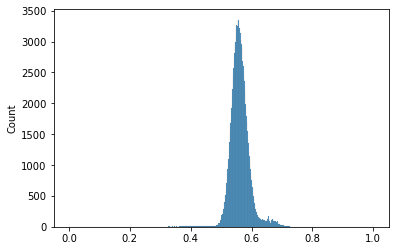

In [136]:
sns.histplot(preds)

По распределению видно, что модель не может четко классифицироват рейтинг.

### Посмотрим какие признаки оказывают наибольшее влияние на целевую переменную

Соберем отдельный датафрейм, чтоб не попортить рабочие.

In [137]:
classif_df = pd.merge(train_df, product_df, on='asin')

In [138]:
classif_df = classif_df[['verified','vote', 'dataAge', 'dateReview_week', 'dateReview_month', 
                         'user_reviewer_num', 'item_reviewer_num','rank', 'main_cat', 'price', 
                         'num_category_1', 'num_category_2', 'num_category_3','rating', 'style_size_num']].copy()

In [139]:
classif_df['dateReview_week_all'] = classif_df['dateReview_week']
classif_df['dateReview_month_all'] = classif_df['dateReview_month']
classif_df['main_cat_all'] = classif_df['main_cat']
classif_df['num_category_1_all'] = classif_df['num_category_1']

classif_df = pd.get_dummies(classif_df, columns=['dateReview_week', 'dateReview_month', 'main_cat', 'num_category_1'], prefix_sep = '_')

In [140]:
classif_df['main_cat_all'] = classif_df['main_cat_all'].apply(lambda x: main_cat_all_dict[x])
classif_df['num_category_1_all'] = classif_df['num_category_1_all'].apply(lambda x: num_category_1_all_dict[x])

In [141]:
classif_df

,verified,vote,dataAge,user_reviewer_num,item_reviewer_num,rank,price,num_category_2,num_category_3,rating,...,"num_category_1_Jams, Jellies & Sweet Spreads",num_category_1_Meat & Seafood,num_category_1_Meat Substitutes,"num_category_1_Olives, Pickles & Relishes",num_category_1_Pasta & Noodles,num_category_1_Prepared Foods,num_category_1_Produce,"num_category_1_Sauces, Gravies & Marinades",num_category_1_Snack Foods,"num_category_1_Soups, Stocks & Broths"
0,1,0,728,7,14,"19,771.00000",9.95000,Mixed Spices & Seasonings,Adobo Seasoning,1.00000,...,0,0,0,0,0,0,0,0,0,0
1,0,0,550,5,14,"19,771.00000",9.95000,Mixed Spices & Seasonings,Adobo Seasoning,1.00000,...,0,0,0,0,0,0,0,0,0,0
2,1,4,570,10,14,"19,771.00000",9.95000,Mixed Spices & Seasonings,Adobo Seasoning,-1.00000,...,0,0,0,0,0,0,0,0,0,0
3,0,0,867,5,14,"19,771.00000",9.95000,Mixed Spices & Seasonings,Adobo Seasoning,1.00000,...,0,0,0,0,0,0,0,0,0,0
4,0,0,867,5,14,"19,771.00000",9.95000,Mixed Spices & Seasonings,Adobo Seasoning,1.00000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826890,1,0,521,5,1,"212,433.00000",30.99000,Candy & Chocolate Bars,Candy & Chocolate Bars,1.00000,...,0,0,0,0,0,0,0,0,0,0
826891,0,0,32,5,5,"150,108.00000",18.68000,Nut & Seed Butters,Peanut Butter,1.00000,...,1,0,0,0,0,0,0,0,0,0
826892,1,0,1072,5,5,"14,497.00000",33.10000,"Coffee, Tea & Cocoa",Coffee,1.00000,...,0,0,0,0,0,0,0,0,0,0
826893,1,0,1302,6,6,"443,322.00000",15.99000,"Coffee, Tea & Cocoa",Tea,1.00000,...,0,0,0,0,0,0,0,0,0,0


In [142]:
# Стандартизируем:
scaler_cl = MinMaxScaler()
col_st = classif_df.drop(['rating','num_category_2', 'num_category_3'], axis=1).columns
classif_df[col_st] = pd.DataFrame(scaler_cl.fit_transform(classif_df[col_st]))

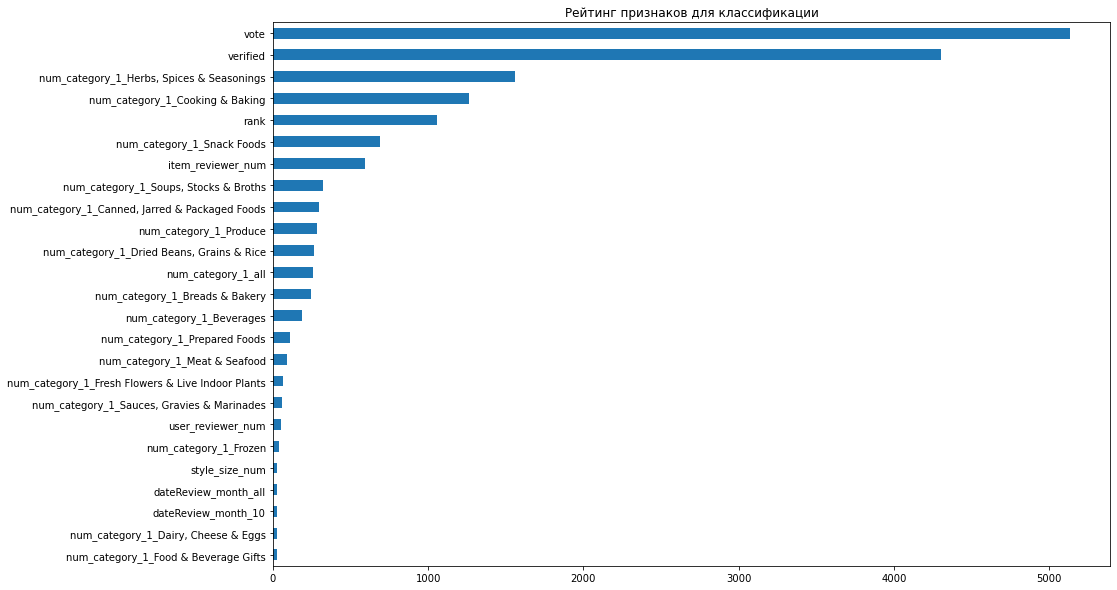

In [143]:
importance_features = pd.Series(f_classif(classif_df[col_st], 
                           classif_df['rating'])[0], index = col_st)

importance_features = importance_features.sort_values()

plt.figure(figsize=(15, 10))
plt.title('Рейтинг признаков для классификации')
importance_features[45:].plot(kind = 'barh')
plt.show()

Самое большое значение имеют колонки:
1. 'vote', 'verified' и 'rank'.
2. 'item_reviewer_num' и 'user_reviewer_num'
3. Разбивка дамп-переменными по 'num_category_1'

### Соберем разные списки колонок для обучения и обучим на них:

In [144]:
feature_df_items = feature_df.groupby('itemid').median()
feature_df_users = feature_df.groupby('userid').median()

In [145]:
feature_df_items['item_index'] = feature_df_items.index
feature_df_users['user_index'] = feature_df_users.index

### Стандартизируем данные

In [146]:
scaler = MinMaxScaler()
col_standart = ['vote','dataAge', 'dateReview_week_all', 'dateReview_month_all', 'user_reviewer_num', 'rank',
                'price', 'item_reviewer_num', 'num_category_1_all', 'main_cat_all', 'style_size_num']
feature_df_items[col_standart] = pd.DataFrame(scaler.fit_transform(feature_df_items[col_standart]))
feature_df_users[col_standart] = pd.DataFrame(scaler.fit_transform(feature_df_users[col_standart]))

feature_df_users.describe()

,itemid,verified,vote,dataAge,style_size_num,user_reviewer_num,item_reviewer_num,rank,price,dateReview_week_all,...,num_category_1_Meat & Seafood,num_category_1_Meat Substitutes,"num_category_1_Olives, Pickles & Relishes",num_category_1_Pasta & Noodles,num_category_1_Prepared Foods,num_category_1_Produce,"num_category_1_Sauces, Gravies & Marinades",num_category_1_Snack Foods,"num_category_1_Soups, Stocks & Broths",user_index
count,"127,496.00000","127,496.00000","127,496.00000","127,496.00000","127,496.00000","127,496.00000","127,496.00000","127,496.00000","127,496.00000","127,496.00000",...,"127,496.00000","127,496.00000","127,496.00000","127,496.00000","127,496.00000","127,496.00000","127,496.00000","127,496.00000","127,496.00000","127,496.00000"
mean,"16,902.43940",0.93343,0.01904,0.50718,0.02723,0.01523,0.04660,0.10313,0.18217,0.48027,...,0.00025,0.00011,0.00027,0.00093,0.00010,0.00507,0.00262,0.05655,0.00447,"63,747.50000"
std,"7,946.31918",0.24374,0.09102,0.23089,0.10470,0.01647,0.14385,0.09168,0.06073,0.27237,...,0.01462,0.01000,0.01534,0.02902,0.00874,0.06785,0.04860,0.22106,0.06409,"36,805.06930"
min,41.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,"10,635.50000",1.00000,0.00000,0.32592,0.00000,0.00828,0.00538,0.03566,0.14087,0.33333,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,"31,873.75000"
50%,"16,534.00000",1.00000,0.00000,0.50632,0.00000,0.01035,0.01103,0.07233,0.17336,0.50000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,"63,747.50000"
75%,"23,083.00000",1.00000,0.00000,0.69126,0.00000,0.01656,0.02500,0.14468,0.21234,0.66667,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,"95,621.25000"
max,"41,097.00000",1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,"127,495.00000"


In [147]:
feature_df_items.describe()

,userid,verified,vote,dataAge,style_size_num,user_reviewer_num,item_reviewer_num,rank,price,dateReview_week_all,...,num_category_1_Meat & Seafood,num_category_1_Meat Substitutes,"num_category_1_Olives, Pickles & Relishes",num_category_1_Pasta & Noodles,num_category_1_Prepared Foods,num_category_1_Produce,"num_category_1_Sauces, Gravies & Marinades",num_category_1_Snack Foods,"num_category_1_Soups, Stocks & Broths",item_index
count,"41,320.00000","41,320.00000","41,320.00000","41,320.00000","41,320.00000","41,320.00000","41,320.00000","41,320.00000","41,320.00000","41,320.00000",...,"41,320.00000","41,320.00000","41,320.00000","41,320.00000","41,320.00000","41,320.00000","41,320.00000","41,320.00000","41,320.00000","41,320.00000"
mean,"55,195.82688",0.95161,0.01688,0.52125,0.04623,0.02667,0.00382,0.17150,0.02106,0.47930,...,0.00908,0.00198,0.00622,0.01065,0.00249,0.02444,0.02924,0.11445,0.01912,"20,659.50000"
std,"22,799.59548",0.20828,0.07789,0.21220,0.15586,0.01706,0.01299,0.16031,0.01482,0.16575,...,0.09483,0.04450,0.07862,0.10264,0.04987,0.15442,0.16847,0.31836,0.13695,"11,928.20090"
min,5.50000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,"39,082.75000",1.00000,0.00000,0.34931,0.00000,0.01752,0.00077,0.04103,0.01396,0.33333,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,"10,329.75000"
50%,"54,147.00000",1.00000,0.00000,0.51375,0.00000,0.02336,0.00139,0.12758,0.01846,0.50000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,"20,659.50000"
75%,"70,351.25000",1.00000,0.00000,0.69079,0.00000,0.02920,0.00324,0.26488,0.02535,0.58333,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,"30,989.25000"
max,"127,495.00000",1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,"41,319.00000"


In [148]:
col_list_i1 = ['vote', 'verified', 'rank']
col_list_u1 = ['vote', 'verified', 'rank']

items_coo_cols_1 = sparse.coo_matrix(feature_df_items[col_list_i1])
users_coo_cols_1 = sparse.coo_matrix(feature_df_users[col_list_u1])

items_coo = sparse.coo_matrix(([1]*len(feature_df_items),(feature_df_items.item_index,feature_df_items.item_index)))
users_coo = sparse.coo_matrix(([1]*len(feature_df_users),(feature_df_users.user_index,feature_df_users.user_index)))

items_coo_1 = sparse.bmat([[items_coo,items_coo_cols_1]])
users_coo_1 = sparse.bmat([[users_coo,users_coo_cols_1]])

In [149]:
model_1 = LightFM(learning_rate = LEARNING_RATE, 
                loss = LOSS_FUNC,
                no_components = NUM_COMPONENTS,
                random_state = RANDOM_STATE)

model_1 = model_1.fit(ratings_coo, epochs=NUM_EPOCHS, num_threads=NUM_THREADS,
                      item_features=items_coo_1, user_features=users_coo_1)

preds_1 = model_1.predict(X_test.userid.values, X_test.itemid.values, 
                          item_features=items_coo_1, user_features=users_coo_1)

preds_1 = get_norm(preds_1)

metrics_model['model_1'] = get_metrics(get_norm(X_test.rating), preds_1)

mse:  0.31444708654008824
mae:  0.5529001647441232
roc-auc:  0.7151360195418125


<AxesSubplot:ylabel='Count'>

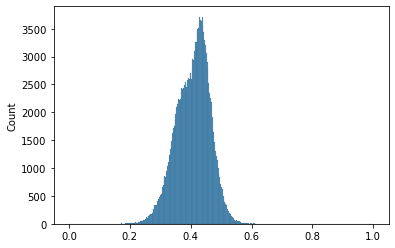

In [150]:
sns.histplot(preds_1)

In [151]:
col_list_i2 = ['vote', 'verified', 'rank', 'item_reviewer_num']
col_list_u2 = ['vote', 'verified', 'rank', 'user_reviewer_num']

items_coo_cols_2 = sparse.coo_matrix(feature_df_items[col_list_i2])
users_coo_cols_2 = sparse.coo_matrix(feature_df_users[col_list_u2])

items_coo_2 = sparse.bmat([[items_coo,items_coo_cols_2]])
users_coo_2 = sparse.bmat([[users_coo,users_coo_cols_2]])

In [152]:
model_2 = LightFM(learning_rate = LEARNING_RATE, 
                loss = LOSS_FUNC,
                no_components = NUM_COMPONENTS,
                random_state = RANDOM_STATE)

model_2 = model_2.fit(ratings_coo, epochs=NUM_EPOCHS, num_threads=NUM_THREADS,
                      item_features=items_coo_2, user_features=users_coo_2)

preds_2 = model_2.predict(X_test.userid.values, X_test.itemid.values, 
                          item_features=items_coo_2, user_features=users_coo_2)

preds_2 = get_norm(preds_2)

metrics_model['model_2'] = get_metrics(get_norm(X_test.rating), preds_2)

mse:  0.2499464654120499
mae:  0.49676375111613774
roc-auc:  0.7174454549631908


<AxesSubplot:ylabel='Count'>

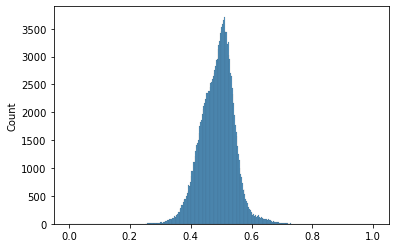

In [153]:
sns.histplot(preds_2)

In [154]:
col_list_i3 = ['vote', 'verified', 'rank', 'item_reviewer_num',
               'num_category_1_Alcoholic Beverages', 'num_category_1_Beverages',
               'num_category_1_Breads & Bakery', 'num_category_1_Breakfast Foods',
               'num_category_1_Candy & Chocolate',
               'num_category_1_Canned, Jarred & Packaged Foods',
               'num_category_1_Condiments & Salad Dressings',
               'num_category_1_Cooking & Baking',
               'num_category_1_Dairy, Cheese & Eggs', 'num_category_1_Deli',
               'num_category_1_Dried Beans, Grains & Rice',
               'num_category_1_Food & Beverage Gifts',
               'num_category_1_Fresh Flowers & Live Indoor Plants',
               'num_category_1_Frozen', 'num_category_1_Herbs, Spices & Seasonings',
               'num_category_1_Jams, Jellies & Sweet Spreads',
               'num_category_1_Meat & Seafood', 'num_category_1_Meat Substitutes',
               'num_category_1_Olives, Pickles & Relishes',
               'num_category_1_Pasta & Noodles', 'num_category_1_Prepared Foods',
               'num_category_1_Produce', 'num_category_1_Sauces, Gravies & Marinades',
               'num_category_1_Snack Foods', 'num_category_1_Soups, Stocks & Broths']
col_list_u3 = ['vote', 'verified', 'rank', 'user_reviewer_num',
               'num_category_1_Alcoholic Beverages', 'num_category_1_Beverages',
               'num_category_1_Breads & Bakery', 'num_category_1_Breakfast Foods',
               'num_category_1_Candy & Chocolate',
               'num_category_1_Canned, Jarred & Packaged Foods',
               'num_category_1_Condiments & Salad Dressings',
               'num_category_1_Cooking & Baking',
               'num_category_1_Dairy, Cheese & Eggs', 'num_category_1_Deli',
               'num_category_1_Dried Beans, Grains & Rice',
               'num_category_1_Food & Beverage Gifts',
               'num_category_1_Fresh Flowers & Live Indoor Plants',
               'num_category_1_Frozen', 'num_category_1_Herbs, Spices & Seasonings',
               'num_category_1_Jams, Jellies & Sweet Spreads',
               'num_category_1_Meat & Seafood', 'num_category_1_Meat Substitutes',
               'num_category_1_Olives, Pickles & Relishes',
               'num_category_1_Pasta & Noodles', 'num_category_1_Prepared Foods',
               'num_category_1_Produce', 'num_category_1_Sauces, Gravies & Marinades',
               'num_category_1_Snack Foods', 'num_category_1_Soups, Stocks & Broths']

items_coo_cols_3 = sparse.coo_matrix(feature_df_items[col_list_i3])
users_coo_cols_3 = sparse.coo_matrix(feature_df_users[col_list_u3])

items_coo_3 = sparse.bmat([[items_coo,items_coo_cols_3]])
users_coo_3 = sparse.bmat([[users_coo,users_coo_cols_3]])

In [155]:
model_3 = LightFM(learning_rate = LEARNING_RATE, 
                loss = LOSS_FUNC,
                no_components = NUM_COMPONENTS,
                random_state = RANDOM_STATE)

model_3 = model_3.fit(ratings_coo, epochs=NUM_EPOCHS, num_threads=NUM_THREADS,
                      item_features=items_coo_3, user_features=users_coo_3)

preds_3 = model_3.predict(X_test.userid.values, X_test.itemid.values, 
                          item_features=items_coo_3, user_features=users_coo_3)

preds_3 = get_norm(preds_3)

metrics_model['model_3'] = get_metrics(get_norm(X_test.rating), preds_3)

mse:  0.23162645505389792
mae:  0.4760709189108119
roc-auc:  0.7196397320359199


<AxesSubplot:ylabel='Count'>

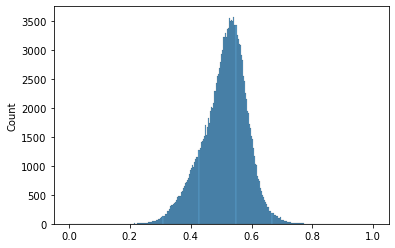

In [156]:
sns.histplot(preds_3)

**Попробуем менять и добавлять еще разные признаки исходя из логики и здравого смысла**

In [157]:
col_list_i4 = ['item_reviewer_num', 'price', 
               'main_cat_All Beauty', 'main_cat_Amazon Home',
               'main_cat_Arts, Crafts & Sewing', 'main_cat_Baby',
               'main_cat_Cell Phones & Accessories', 'main_cat_Electronics',
               'main_cat_Grocery', 'main_cat_Health & Personal Care',
               'main_cat_Industrial & Scientific', 'main_cat_Office Products',
               'main_cat_Pet Supplies', 'main_cat_Sports & Outdoors',
               'main_cat_Tools & Home Improvement', 'main_cat_Toys & Games']
col_list_u4 = ['user_reviewer_num', 'price']


items_coo_cols_4 = sparse.coo_matrix(feature_df_items[col_list_i4])
users_coo_cols_4 = sparse.coo_matrix(feature_df_users[col_list_u4])

items_coo_4 = sparse.bmat([[items_coo,items_coo_cols_4]])
users_coo_4 = sparse.bmat([[users_coo,users_coo_cols_4]])

In [158]:
model_4 = LightFM(learning_rate = LEARNING_RATE, 
                loss = LOSS_FUNC,
                no_components = NUM_COMPONENTS,
                random_state = RANDOM_STATE)

model_4 = model_4.fit(ratings_coo, epochs=NUM_EPOCHS, num_threads=NUM_THREADS,
                      item_features=items_coo_4, user_features=users_coo_4)

preds_4 = model_4.predict(X_test.userid.values, X_test.itemid.values, 
                          item_features=items_coo_4, user_features=users_coo_4)

preds_4 = get_norm(preds_4)

metrics_model['model_4'] = get_metrics(get_norm(X_test.rating), preds_4)

mse:  0.271880518045264
mae:  0.5169992420131246
roc-auc:  0.7293810700794354


<AxesSubplot:ylabel='Count'>

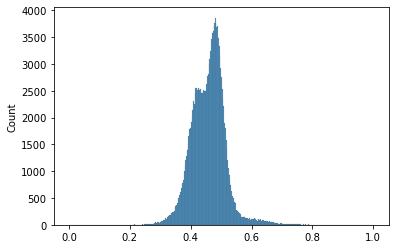

In [159]:
sns.histplot(preds_4)

In [160]:
# Все колонки
col_list_i5 = col_st
col_list_u5 = col_st

items_coo_cols_5 = sparse.coo_matrix(feature_df_items[col_list_i5])
users_coo_cols_5 = sparse.coo_matrix(feature_df_users[col_list_u5])

items_coo_5 = sparse.bmat([[items_coo,items_coo_cols_5]])
users_coo_5 = sparse.bmat([[users_coo,users_coo_cols_5]])

In [161]:
model_5 = LightFM(learning_rate = LEARNING_RATE, 
                loss = LOSS_FUNC,
                no_components = NUM_COMPONENTS,
                random_state = RANDOM_STATE)

model_5 = model_5.fit(ratings_coo, epochs=NUM_EPOCHS, num_threads=NUM_THREADS,
                      item_features=items_coo_5, user_features=users_coo_5)

preds_5 = model_5.predict(X_test.userid.values, X_test.itemid.values, 
                          item_features=items_coo_5, user_features=users_coo_5)

preds_5 = get_norm(preds_5)

metrics_model['model_5'] = get_metrics(get_norm(X_test.rating), preds_5)

mse:  0.2040591460218652
mae:  0.4406342220020256
roc-auc:  0.7219890883544741


<AxesSubplot:ylabel='Count'>

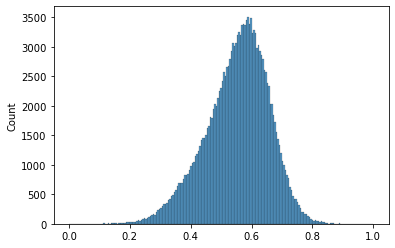

In [162]:
sns.histplot(preds_5)

In [163]:
col_list_i6 = ['item_reviewer_num', 'price']
col_list_u6 = ['user_reviewer_num', 'price']


items_coo_cols_6 = sparse.coo_matrix(feature_df_items[col_list_i6])
users_coo_cols_6= sparse.coo_matrix(feature_df_users[col_list_u6])

items_coo_6 = sparse.bmat([[items_coo,items_coo_cols_6]])
users_coo_6 = sparse.bmat([[users_coo,users_coo_cols_6]])

In [164]:
model_6 = LightFM(learning_rate = LEARNING_RATE, 
                loss = LOSS_FUNC,
                no_components = NUM_COMPONENTS,
                random_state = RANDOM_STATE)

model_6 = model_6.fit(ratings_coo, epochs=NUM_EPOCHS, num_threads=NUM_THREADS,
                      item_features=items_coo_6, user_features=users_coo_6)

preds_6 = model_6.predict(X_test.userid.values, X_test.itemid.values, 
                          item_features=items_coo_6, user_features=users_coo_6)

preds_6 = get_norm(preds_6)

metrics_model['model_6'] = get_metrics(get_norm(X_test.rating), preds_6)

mse:  0.24080253455819475
mae:  0.48952687657583704
roc-auc:  0.7251827615507462


<AxesSubplot:ylabel='Count'>

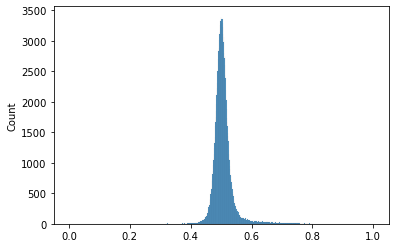

In [165]:
sns.histplot(preds_6)

In [166]:
col_list_i7 = ['item_reviewer_num', 'main_cat_all', 'num_category_1_all']
col_list_u7 = ['user_reviewer_num', 'price', 'verified']


items_coo_cols_7 = sparse.coo_matrix(feature_df_items[col_list_i7])
users_coo_cols_7= sparse.coo_matrix(feature_df_users[col_list_u7])

items_coo_7 = sparse.bmat([[items_coo,items_coo_cols_7]])
users_coo_7 = sparse.bmat([[users_coo,users_coo_cols_7]])

In [167]:
model_7 = LightFM(learning_rate = LEARNING_RATE, 
                loss = LOSS_FUNC,
                no_components = NUM_COMPONENTS,
                random_state = RANDOM_STATE)

model_7 = model_7.fit(ratings_coo, epochs=NUM_EPOCHS, num_threads=NUM_THREADS,
                      item_features=items_coo_7, user_features=users_coo_7)

preds_7 = model_7.predict(X_test.userid.values, X_test.itemid.values, 
                          item_features=items_coo_7, user_features=users_coo_7)

preds_7 = get_norm(preds_7)

metrics_model['model_7'] = get_metrics(get_norm(X_test.rating), preds_7)

mse:  0.2634067123702998
mae:  0.5080702691173983
roc-auc:  0.7263833867287777


<AxesSubplot:ylabel='Count'>

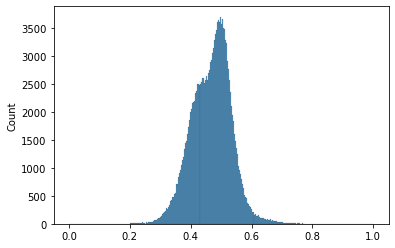

In [168]:
sns.histplot(preds_7)

**Итог обучения**

In [169]:
df_metrics = pd.DataFrame(metrics_model)

In [170]:
df_metrics 

,model,model_1,model_2,model_3,model_4,model_5,model_6,model_7
mse,0.20475,0.31445,0.24995,0.23163,0.27188,0.20406,0.24080,0.26341
mae,0.44981,0.55290,0.49676,0.47607,0.51700,0.44063,0.48953,0.50807
roc-auc,0.73087,0.71514,0.71745,0.71964,0.72938,0.72199,0.72518,0.72638


Как видим из представленных данных самый хороший результат дает базовая модель (без учета признаков по товарам и покупателям) и модель 5 (все признаки, которые есть). 

По гистограммам предсказаний видно, что модели не могут разнести предсказания по крайностям хорошо-плохо. Большинство ответов находится посередине. Гистограма в форме колокола, а ожидалось наоборот, по центру мало и увеличение в основном к 1 и немного к 0, так как дисбаланс выборки. 

При добавлении выборочной информации о товаре и покупателях качество прогноза снижалось. По метрики roc-auc особенно низким было на признаках, которые отобраны на основе f_classif. Осмысленный подбор дал немного получше результат на ней. Но пришлось поварьировать с разными наборами. Оставила самые адекватные, которые показали лучше результат на тренировочных данных, а не лидербрде.

Наверное, здесь лучше было бы применить нейросети (говорилось в конце блока рекомендательных систем, что они дают лучший результат), но мы их не проходили.

Так как ничего лучшего добиться по моделям не удалось, то будем ориентироваться на результат метрики roc-auc, котра используется на лидерборде.

**Выведем средний прогноз, отсортируя модели по результатам метрики**

In [171]:
preds_all = np.zeros((preds.shape[0]))
for i in [preds, preds_4, preds_7, preds_6, preds_5, preds_3, preds_2, preds_1]:
    preds_all = preds_all+i
    print(sklearn.metrics.roc_auc_score(get_norm(X_test.rating), preds_all))


0.7308744950564717
0.7432318567451048
0.7405308040067269
0.7410830870774321
0.7425017066645755
0.7411841719943003
0.7404832571799909
0.739291758911743


Модели 1,2 и 3 ухудшают качество roc-auc при усреднении. Их, наверное, не будем использовать. 

### submission

Чтоб меньше было объектов холодного старта - обучим модель на всем train_df

In [172]:
ratings_coo_sm = sparse.coo_matrix(
    (train_df['rating'].astype(int), (train_df['userid'], train_df['itemid']))
)

**Базовая модель**

In [173]:
model = model.fit(ratings_coo_sm,
                  num_threads=NUM_THREADS,
                  epochs=NUM_EPOCHS)
preds_test = model.predict(test_df.userid.values,
                          test_df.itemid.values)

**Модели с разными признаками, которые дали результат получше**

In [174]:
model_1 = model_1.fit(ratings_coo_sm, epochs=NUM_EPOCHS, num_threads=NUM_THREADS,
                      item_features=items_coo_1, user_features=users_coo_1)

preds_1_test = model_1.predict(test_df.userid.values, test_df.itemid.values, 
                          item_features=items_coo_1, user_features=users_coo_1)

In [175]:
model_2 = model_2.fit(ratings_coo_sm, epochs=NUM_EPOCHS, num_threads=NUM_THREADS,
                      item_features=items_coo_2, user_features=users_coo_2)

preds_2_test = model_2.predict(test_df.userid.values, test_df.itemid.values, 
                          item_features=items_coo_2, user_features=users_coo_2)

In [176]:
model_3 = model_3.fit(ratings_coo_sm, epochs=NUM_EPOCHS, num_threads=NUM_THREADS,
                      item_features=items_coo_3, user_features=users_coo_3)

preds_3_test = model_3.predict(test_df.userid.values, test_df.itemid.values, 
                          item_features=items_coo_3, user_features=users_coo_3)

In [177]:
model_4 = model_4.fit(ratings_coo_sm, epochs=NUM_EPOCHS, num_threads=NUM_THREADS,
                      item_features=items_coo_4, user_features=users_coo_4)

preds_4_test = model_4.predict(test_df.userid.values, test_df.itemid.values, 
                          item_features=items_coo_4, user_features=users_coo_4)

In [178]:
model_5 = model_5.fit(ratings_coo_sm, epochs=NUM_EPOCHS, num_threads=NUM_THREADS,
                      item_features=items_coo_5, user_features=users_coo_5)

preds_5_test = model_5.predict(test_df.userid.values, test_df.itemid.values, 
                          item_features=items_coo_5, user_features=users_coo_5)

In [179]:
model_6 = model_6.fit(ratings_coo_sm, epochs=NUM_EPOCHS, num_threads=NUM_THREADS,
                      item_features=items_coo_6, user_features=users_coo_6)

preds_6_test = model_6.predict(test_df.userid.values, test_df.itemid.values, 
                          item_features=items_coo_6, user_features=users_coo_6)

In [180]:
model_7 = model_7.fit(ratings_coo_sm, epochs=NUM_EPOCHS, num_threads=NUM_THREADS,
                      item_features=items_coo_7, user_features=users_coo_7)

preds_7_test = model_7.predict(test_df.userid.values, test_df.itemid.values, 
                          item_features=items_coo_7, user_features=users_coo_7)

Просуммируем и нормализуем результат

In [181]:
preds_test_all = np.zeros((preds_test.shape[0]))
for i in [preds_test, preds_4_test, preds_7_test, preds_6_test, preds_5_test]:  
    preds_norm = get_norm(i)
    preds_test_all = preds_test_all+i

preds_test_norm = get_norm(preds_norm)
preds_test_norm.min(), preds_test_norm.max()

(0.0, 1.0)

In [182]:
submission_pred = submission.copy()

submission_pred['rating']= preds_test_norm
submission_pred.to_csv('data/submission_pred.csv', index=False)

<AxesSubplot:xlabel='rating', ylabel='Count'>

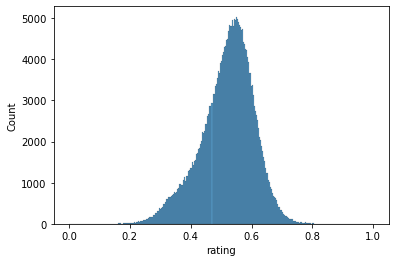

In [183]:
sns.histplot(submission_pred.rating)

### Заключение:

Если рассматривать индивидуально каждую модель, то самый хороший результат дает пересечение продукта и покупателя (базова модель без дополнительных признаков) и модель 5 (которая учитывает все признаки, которые есть).

Чтоб улучшить результат базового набора и сделать более стабильное предсказание, ориентируясь на метрику roc-auc:
    
    собрала для нескольких моделей свой состав признаков и просуммировала пронормированные результы.

Но модели не смогли разделить предсказания на плохо-хорошо. По гистограммам видим, что предсказания распределились в форме колокола (нормальное распределение), т.е. в большинстве своем модель сомневается.

Для прогнозирования была использована вся обучающая выборка, чтоб сократить количество объектов холодного старта.
На лидерборде простая базовая модель дает лучше результат, чем комбинированние базовой с признакавыми. Но по обучающей выборке лучше вариант базовая + модели 4-7. Так я и оставлю.

По поводу холодного старта:
    
    * для покупателей, предполагаю, что оптимальным вариантом будет предложить в качестве рекоммендаций наиболее популярные товары.
    
    * для товаров, возможно, добавлять к блоку рекомендаций новый товар (например 4+1) той же категории, что и основные рекомендуемые. Постепенно знакомить полкупателей с новым ассортиментом. Так же можно выделить его лейбочкой как новинка, чтоб привлечь внимание.
    

В блоке по рекомендательным системам говорилось, что лучший результат дают нейронные сети. Надо будет вернуться к этому заданию после их прохождения и попробовать улучшить результат предсказания.


Поле внедрения системы можно было бы использовать метрики посчитанные на топ_N записях precision@N, recall@N. Провести А/В тестирование по продажам (количество товаров и сумма). Если предлагается сопутствующие товары, то продажи и по сопутсвующим категорям. Кликабельность/положии в корзину/купили рекомендованные товары.


